 # Breast Cancer Mass Detection with EfficientDet

# Necessary Imports

In [1]:
# Dataset Operations
import numpy as np
import pandas as pd

# File Operations
import os

# Model Operations
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
# Others
import glob
print("Done")

Done


In [2]:
############  TEST  ############
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

Num GPUs Available: 1
The following GPU devices are available: /device:GPU:0


# Data Preprocessing

## Load the Dataset 

In [17]:
def resize_image(image_path, target_size=(640, 640)):
    """
    This function loads an image from the given file path, pads it to a square shape with zeros, 
    and then resizes it to the target size.

    Parameters:
    image_path (str): The file path to the image.
    target_size (tuple): The target size in the format (width, height).

    Returns:
    np.array: The resized image.
    """
    # Load the image from the file path
    image = cv2.imread(image_path)
    
    # Get the original size of the image
    original_dimensions = (image.shape[1], image.shape[0])
    
    # Determine the longer side to use as the size for both dimensions
    max_side = max(image.shape[:2])
    
    # Calculate padding for the top, bottom, left, and right
    top = (max_side - image.shape[0]) // 2
    bottom = max_side - image.shape[0] - top
    left = (max_side - image.shape[1]) // 2
    right = max_side - image.shape[1] - left
    
    # Apply padding to make the image square
    image_padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # Resize the padded image to the target size
    resized_image = cv2.resize(image_padded, target_size)
    
    return resized_image

In [18]:
def adjust_and_scale_bounding_box(bbox, padded_size, new_size=(640, 640)):
    """
    Scale the bounding box coordinates based on the resizing of the image.

    Parameters:
    bbox (list): The bounding box coordinates in the format [x1, y1, x2, y2, x3, y3, x4, y4].
    padded_size (tuple): The padded size of the original image, in the format (width, height).
    new_size (tuple): The new size of the image after resizing, in the format (width, height).

    Returns:
    list: The scaled bounding box coordinates in the format [y1(ymin), x1(xmin), y3(ymax), x3(xmax)].
    """
    padded_width, padded_height = padded_size
    new_width, new_height = new_size
    
    # Calculate scaling factors
    scale_x = new_width / padded_width
    scale_y = new_height / padded_height
    
    # Scale the coordinates
    scaled_bbox = []
    for i in range(0, len(bbox), 2):
        x = bbox[i]
        y = bbox[i + 1]
        scaled_bbox.append(x * scale_x)
        scaled_bbox.append(y * scale_y)
    
    # Calculate the offsets
    x_offset = new_width / 2
    y_offset = new_height / 2

    # Adjust the coordinates
    adjusted_bounding_box = []
    for i in range(len(scaled_bbox)):
        if(i % 2 == 0): # x-coordinates
            adjusted_bounding_box.append(scaled_bbox[i] + x_offset)
        else: # y-coordinates
            adjusted_bounding_box.append(scaled_bbox[i] + y_offset)

    # New bounding box format: [ymin, xmin, ymax, xmax]
    ymin = min(adjusted_bounding_box[1], adjusted_bounding_box[3], adjusted_bounding_box[5], adjusted_bounding_box[7])
    xmin = min(adjusted_bounding_box[0], adjusted_bounding_box[2], adjusted_bounding_box[4], adjusted_bounding_box[6])
    ymax = max(adjusted_bounding_box[1], adjusted_bounding_box[3], adjusted_bounding_box[5], adjusted_bounding_box[7])
    xmax = max(adjusted_bounding_box[0], adjusted_bounding_box[2], adjusted_bounding_box[4], adjusted_bounding_box[6])
    
    return [ymin, xmin, ymax, xmax]

In [20]:
def extract_bounding_box_coordinates(bounding_box_list):
    new_list = []
    for bounding_box in bounding_box_list:
        x = float(bounding_box.split('/')[0])
        y = float(bounding_box.split('/')[1])
        new_list.append(x)
        new_list.append(y)
    return new_list

In [21]:
def create_example(image, labels, bounding_boxes_list):
    """
    Create a TFRecord from the image, labels, and bounding boxes.

    Parameters:
    image (np.array): The image to be stored in the TFRecord.
    labels (list): A list of labels corresponding to each bounding box.
    bounding_boxes_list (list): A list of bounding box coordinates, each in the format [ymin, xmin, ymax, xmax].

    Returns:
    tf.train.Example: The TFRecord example.
    """
    height, width, _ = image.shape

    # Encode the image
    encoded_image = tf.io.encode_jpeg(image).numpy()

    # Initialize lists to store normalized coordinates
    ymins = []
    xmins = []
    ymaxs = []
    xmaxs = []

    for bbox in bounding_boxes_list:
        ymin, xmin, ymax, xmax = bbox
        ymins.append(ymin / height)
        xmins.append(xmin / width)
        ymaxs.append(ymax / height)
        xmaxs.append(xmax / width)

    # Create the feature dictionary
    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpeg'])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=labels))
    }

    # Return a tf.train.Example
    return tf.train.Example(features=tf.train.Features(feature=feature))                                            

In [22]:
def create_tfrecord(image, label, bounding_boxes_list, output_path):
    """
    Create a TFRecord file for a single image.

    Parameters:
    image (np.array): The image to be stored in the TFRecord.
    label (int): The label of the image.
    bounding_boxes_list (list): A list of bounding box coordinates, each in the format [ymin, xmin, ymax, xmax].
    output_path (str): The output path for the TFRecord file.
    """
    tf_example = create_example(image, label, bounding_boxes_list)
    
    with tf.io.TFRecordWriter(output_path) as writer:
        writer.write(tf_example.SerializeToString())

## Load the csv file

In [23]:
def convert_images_to_tfrecords(image_root, tfrecord_root, bbox_data_csv_path):
    """
    Converts images and bounding box data into TFRecord format.

    Parameters:
    - image_root: The root directory containing the images.
    - tfrecord_root: The directory where the TFRecord files will be saved.
    - bbox_data_csv_path: The path to the CSV file containing bounding box data.
    """

    # Load the CSV file into a DataFrame
    bbox_data = pd.read_csv(bbox_data_csv_path, delimiter=";")

    bbox_data = bbox_data[bbox_data['label_name'] == "mass"]

    # Add a new column for the modified file name (to .jpeg)
    bbox_data['modified_file_name'] = bbox_data['file_name'].apply(lambda x: os.path.splitext(x)[0] + ".jpeg")

    # Group by 'category', 'patient_id', and 'modified_file_name'
    grouped = bbox_data.groupby(['category', 'patient_id', 'modified_file_name'])

    for (category, patient_id, modified_file_name), group in grouped:
        # Construct the file path for the image
        file_path_train = os.path.join(image_root, "train", category, str(patient_id), modified_file_name)
        file_path_test = os.path.join(image_root, "test", category, str(patient_id), modified_file_name)

        # Determine the correct file path
        if os.path.exists(file_path_train):
            file_path = file_path_train
            tfrecord_subdir = "train"
        elif os.path.exists(file_path_test):
            file_path = file_path_test
            tfrecord_subdir = "test"
        else:
            print(f"File not found in both train and test directories: {category, patient_id, modified_file_name}")
            continue

        # Resize the image
        image = resize_image(file_path)

        # Collect all bounding boxes and labels for this image
        bounding_boxes_list = []
        labels = []
        for _, row in group.iterrows():
            if pd.notna(row['label_coordinates']):
                bounding_box_list = row['label_coordinates'].split('|')
                bounding_box = extract_bounding_box_coordinates(bounding_box_list)
                bounding_box = adjust_and_scale_bounding_box(bounding_box, (2964, 2964))
                bounding_boxes_list.append(bounding_box)
                labels.append(1)  # Label is 1 for "mass"

        # Define the output path for the TFRecord
        tfrecord_dir = os.path.join(tfrecord_root, tfrecord_subdir, category, str(patient_id))
        tfrecord_path = os.path.join(tfrecord_dir, f"{os.path.splitext(modified_file_name)[0]}.tfrecord")

        # Create the directory if it does not exist
        os.makedirs(tfrecord_dir, exist_ok=True)

        # Check if the TFRecord file already exists
        if os.path.exists(tfrecord_path):
            print(f"TFRecord already exists: {tfrecord_path}")
            continue

        # Create a TFRecord for the image
        create_tfrecord(image, labels, bounding_boxes_list, tfrecord_path)

In [24]:
# convert_images_to_tfrecords(<hidden_path>, <hidden_path>, <hidden_path>)

 ## Checks before model training

In [25]:
import tensorflow as tf

def print_tfrecord_contents(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value='jpeg'),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    for parsed_record in parsed_dataset.take(1):
        try:
            image_encoded = parsed_record['image/encoded'].numpy()
            filename = parsed_record['image/filename'].numpy().decode('utf-8')
            image_format = parsed_record['image/format'].numpy().decode('utf-8')
            height = parsed_record['image/height'].numpy()
            width = parsed_record['image/width'].numpy()
            xmin = tf.sparse.to_dense(parsed_record['image/object/bbox/xmin'], default_value=0).numpy()
            xmax = tf.sparse.to_dense(parsed_record['image/object/bbox/xmax'], default_value=0).numpy()
            ymin = tf.sparse.to_dense(parsed_record['image/object/bbox/ymin'], default_value=0).numpy()
            ymax = tf.sparse.to_dense(parsed_record['image/object/bbox/ymax'], default_value=0).numpy()
            labels = tf.sparse.to_dense(parsed_record['image/object/class/label'], default_value=-1).numpy()

            print(f"Filename: {filename}")
            print(f"Image Format: {image_format}")
            print(f"Height: {height}, Width: {width}")
            print(f"Bounding Boxes (ymin, xmin, ymax, xmax):")
            for i in range(len(xmin)):
                print(f"  Box {i + 1}: ({ymin[i]}, {xmin[i]}, {ymax[i]}, {xmax[i]})")
            print(f"Labels: {labels}")
        except Exception as e:
            print(f"Error processing record: {e}")

In [15]:
import matplotlib.patches as patches

def visualize_bounding_boxes(image_path, bounding_boxes):
    """
    Visualizes bounding boxes on the image.

    Parameters:
    image_path (str): The path to the image file.
    bounding_boxes (list): List of bounding boxes with each box in the format [ymin, xmin, ymax, xmax].
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the image to a numpy array
    image_np = image.numpy()
    height, width, _ = image_np.shape

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_np)

    # Iterate over bounding boxes and add them to the plot
    for box in bounding_boxes:
        ymin, xmin, ymax, xmax = box
        
        # Convert normalized coordinates to pixel values
        xmin_pixel = xmin * width
        xmax_pixel = xmax * width
        ymin_pixel = ymin * height
        ymax_pixel = ymax * height
        print("ymin:",ymin_pixel,"xmin:",xmin_pixel,"ymax:",ymax_pixel,"xmax:",xmax_pixel)

        box_width = xmax_pixel - xmin_pixel
        box_height = ymax_pixel - ymin_pixel
        rect = patches.Rectangle((xmin_pixel, ymin_pixel), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()

ymin: 175.02666473388672 xmin: 434.4541931152344 ymax: 217.4669647216797 xmax: 488.2119369506836
ymin: 270.30887603759766 xmin: 441.8022155761719 ymax: 294.973087310791 xmax: 468.64269256591797


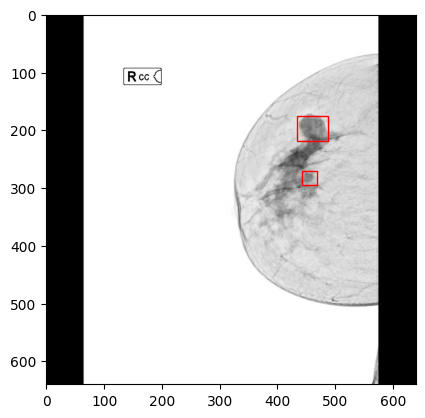

In [28]:
bounding_boxes = [[0.273479163646698, 0.6788346767425537, 0.3397921323776245, 0.7628311514854431],
                  [0.42235761880874634, 0.6903159618377686, 0.46089544892311096, 0.7322542071342468]
                  ]

# visualize_bounding_boxes(<hidden_path>, bounding_boxes)

## Debugging

In [40]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    }
    return tf.io.parse_single_example(example, feature_description)

def inspect_tfrecords(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    for raw_record in raw_dataset:
        example = parse_tfrecord_fn(raw_record)
        labels = tf.sparse.to_dense(example['image/object/class/label']).numpy()
        xmin = tf.sparse.to_dense(example['image/object/bbox/xmin']).numpy()
        xmax = tf.sparse.to_dense(example['image/object/bbox/xmax']).numpy()
        ymin = tf.sparse.to_dense(example['image/object/bbox/ymin']).numpy()
        ymax = tf.sparse.to_dense(example['image/object/bbox/ymax']).numpy()
        
        print(f"Labels: {labels}")
        print(f"Bounding boxes: xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")

# Example usage
def inspect_tfrecords_in_folder(folder_path):
    tfrecord_files = glob.glob(os.path.join(folder_path, '*.tfrecord'))
    for tfrecord_file in tfrecord_files:
        print(f"Inspecting {tfrecord_file}")
        inspect_tfrecords(tfrecord_file)

# folder_path = <hidden_path>
# inspect_tfrecords_in_folder(folder_path)

Inspecting C:/Users/abdulkadir/Documents/TensorFlow/workspace/training_demo/dataset/tfrecords/test/Kategori4\11636-RCC.tfrecord
Labels: [1]
Bounding boxes: xmin=[0.72650087], xmax=[0.7918898], ymin=[0.23337092], ymax=[0.2852311]
Inspecting C:/Users/abdulkadir/Documents/TensorFlow/workspace/training_demo/dataset/tfrecords/test/Kategori4\11636-RMLO.tfrecord
Labels: [1]
Bounding boxes: xmin=[0.5280792], xmax=[0.58557636], ymin=[0.56933486], ymax=[0.638106]
Inspecting C:/Users/abdulkadir/Documents/TensorFlow/workspace/training_demo/dataset/tfrecords/test/Kategori4\11647-RCC.tfrecord
Labels: [1 1]
Bounding boxes: xmin=[0.83698565 0.5393532 ], xmax=[0.89899224 0.56866544], ymin=[0.66854566 0.1544531 ], ymax=[0.75648254 0.1803833 ]
Inspecting C:/Users/abdulkadir/Documents/TensorFlow/workspace/training_demo/dataset/tfrecords/test/Kategori4\11647-RMLO.tfrecord
Labels: [1 1]
Bounding boxes: xmin=[0.77272403 0.5010217 ], xmax=[0.8911005 0.524697 ], ymin=[0.4543405  0.36076662], ymax=[0.59188277 0

KeyboardInterrupt: 

 # Train the model

In [27]:
# Training is done from the terminal
# python model_main_tf2.py --model_dir=models/my_efficientdet_d2_1 --pipeline_config_path=models/my_efficientdet_d2_1/pipeline.config

In [ ]:
# Monitoring the training process
# tensorboard --logdir=models/my_efficientdet_d0_3

## Export the Model

In [ ]:
# Export the model from the terminal
# python .\exporter_main_v2.py --input_type image_tensor --pipeline_config_path .\models\my_efficientdet_d0_5\pipeline.config --trained_checkpoint_dir .\models\my_efficientdet_d0_5\ --output_directory .\exported_models\my_model_5

## Inference

In [12]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt

# Paths
# PATH_TO_SAVED_MODEL = <hidden_path>
# PATH_TO_LABELS = <hidden_path>
# IMAGE_PATH = <hidden_path>

# Load the model
print('Loading model...', end='')
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

# Load label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Function to load an image
def load_image_into_numpy_array(path):
    return np.array(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

# Function to run inference
def run_inference(image_path):
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False)

    return image_np_with_detections

# Run inference and save the results
result_image = run_inference(IMAGE_PATH)

# output_path = <hidden_path>
cv2.imwrite(output_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))

print(f"Result saved to {output_path}")

Loading model...Done!
Result saved to C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\inferences_4\12080-LCC.jpeg


## Evaluate the Model 

In [ ]:
# Evaluation is done from the terminal
# python model_main_tf2.py --model_dir=models/my_efficientdet_d0_5 --pipeline_config_path=models/my_efficientdet_d0_5/pipeline.config --checkpoint_dir=models/my_efficientdet_d0_5